In [42]:
from qiskit.transpiler.coupling import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from qiskit.transpiler import PassManager
from mirror_gates.logging import transpile_benchy_logger
from mirror_gates.sqiswap_decomposer import SiSwapDecomposePass
from qiskit.transpiler.passmanager import PassManager

# Import from Qiskit Aer noise module

In [43]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

In [44]:
cx_basis = False

Loading qft_n4 from QASMBench


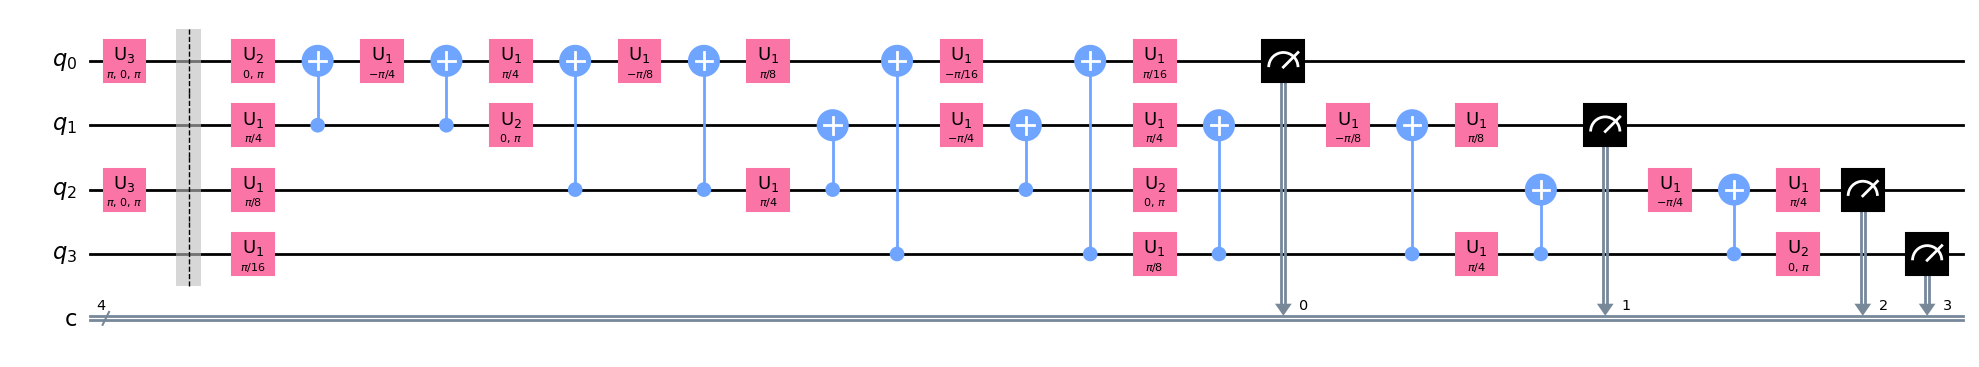

In [45]:
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary(circuit_list=[])
qc = lib.get_circuit("qft_n4")
qc = qc.decompose()
display(qc.draw("mpl", fold=-1))

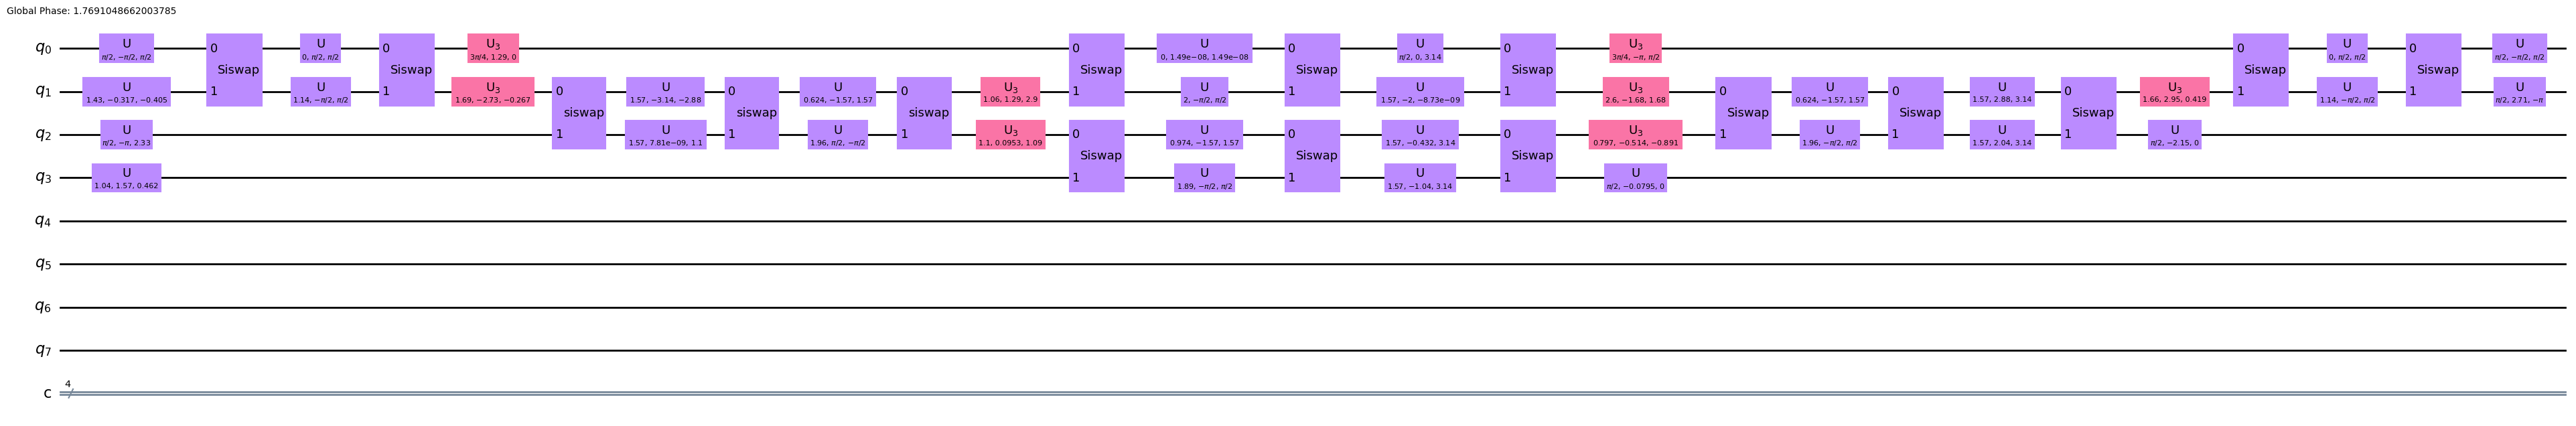

In [46]:
runner = Mirage(
    coupling_map,
    cx_basis=cx_basis,
    logger=transpile_benchy_logger,
)


from qiskit.transpiler.passes import Optimize1qGatesDecomposition

routed = runner.run(qc)
if not cx_basis:
    decomposer = PassManager()
    decomposer.append(SiSwapDecomposePass())
    decomposer.append(Optimize1qGatesDecomposition())
    mirage_output = decomposer.run(routed)
else:
    mirage_output = routed
mirage_output.draw("mpl", fold=-1)

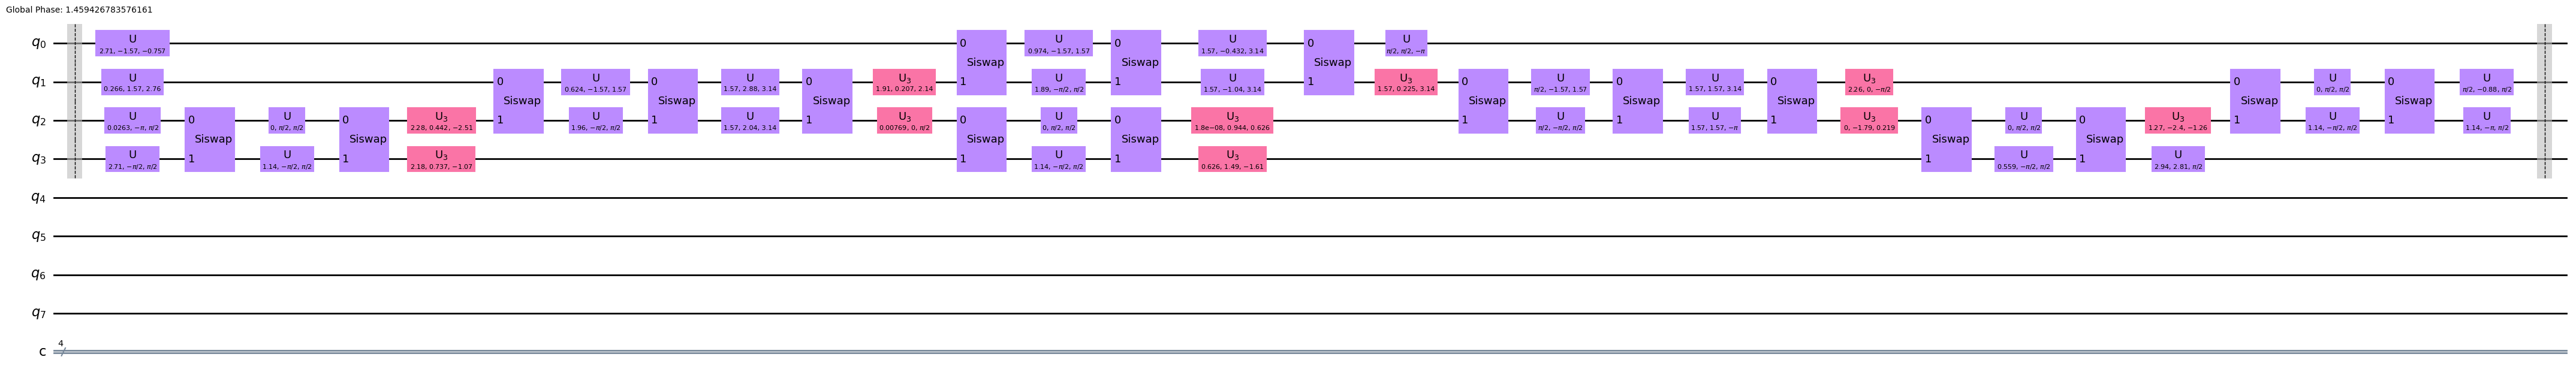

In [47]:
runner = QiskitLevel3(coupling_map, cx_basis=cx_basis)
routed = runner.run(qc)
if not cx_basis:
    decomposer = PassManager()
    decomposer.append(SiSwapDecomposePass())
    decomposer.append(Optimize1qGatesDecomposition())
    qiskit_output = decomposer.run(routed)
else:
    qiskit_output = routed
qiskit_output.draw("mpl", fold=-1)

In [48]:
from mirror_gates.noisy_fidelity import get_noisy_fidelity

a, b, c = get_noisy_fidelity(qiskit_output, coupling_map)
print(f"Fidelity: {a:.3f}, Duration: {b:.3f}")
# display(c.draw("mpl", fold=-1))

a, b, c = get_noisy_fidelity(mirage_output, coupling_map)
print(f"Fidelity: {a:.3f}, Duration: {b:.3f}")
# display(c.draw("mpl", fold=-1))

Fidelity: 0.821, Duration: 1150.000
Fidelity: 0.836, Duration: 1000.000
